## CNN Implementation of the classification task

Assure that you've already executed the notebook of:
- [the preparation of the dataset](prepDataset.ipynb)

The structure of this notebook is as follows:
1. [Load the datasets prepared by the previous notebook](#generate-the-iterator-of-the-datasets)
2. [Define the CNN model](#define-the-cnn-model)
3. Train the model
4. Evaluate the model
5. Save the model

In [1]:
import numpy as np
from joblib import load, dump
import time
import matplotlib.pyplot as plt
import tqdm
from tqdm import trange

## Generate the iterator of the datasets

In [2]:
np.random.seed(100)  # 设置随机种子，以使实验结果具有可重复性

# 加载数据集
def dataloader(batch_size, workers=2):
    def create_batches(xdata, ylabel, batch_size):
        # Shuffling data
        indices = np.arange(xdata.shape[0])
        np.random.shuffle(indices)
        xdata = xdata[indices]
        ylabel = ylabel[indices]
        
        # Creating batches
        num_batches = xdata.shape[0] // batch_size
        batches = []
        for i in range(num_batches):
            x_batch = xdata[i * batch_size:(i + 1) * batch_size]
            y_batch = ylabel[i * batch_size:(i + 1) * batch_size]
            batches.append((x_batch, y_batch))
        
        return batches
    
    # 训练集
    train_xdata = load('files/trainX_512_10c')
    train_ylabel = load('files/trainY_512_10c')
    # 验证集
    val_xdata = load('files/valX_512_10c')
    val_ylabel = load('files/valY_512_10c')
    # 测试集
    test_xdata = load('files/testX_512_10c')
    test_ylabel = load('files/testY_512_10c')

    # 加载数据
    train_loader = create_batches(train_xdata, train_ylabel, batch_size)
    val_loader = create_batches(val_xdata, val_ylabel, batch_size)
    test_loader = create_batches(test_xdata, test_ylabel, batch_size)
    
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

# Example of iterating through batches
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break


51
14
7
(64, 512) (64,)


## Define the CNN Model

In [3]:
class Conv1D:
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = np.random.randn(output_channels, input_channels, kernel_size) * 0.1
        self.bias = np.zeros(output_channels)

    def forward(self, x):
        batch_size, _, seq_length = x.shape
        out_length = (seq_length + 2 * self.padding - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, self.output_channels, out_length))

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding)), mode='constant')

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    out[b, o, i] = np.sum(padded_x[b, :, start:end] * self.weights[o]) + self.bias[o]
        
        self.cache = (x, out)
        return out

    def backward(self, dout, learning_rate=0.01):
        x, out = self.cache
        batch_size, _, seq_length = x.shape
        _, _, out_length = dout.shape

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding)), mode='constant')
        dweights = np.zeros_like(self.weights)
        dbias = np.zeros_like(self.bias)
        dx = np.zeros_like(padded_x)

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    dweights[o] += dout[b, o, i] * padded_x[b, :, start:end]
                    dbias[o] += dout[b, o, i]
                    dx[b, :, start:end] += dout[b, o, i] * self.weights[o]
        
        dx = dx[:, :, self.padding:-self.padding]

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx

In [4]:
class ReLU:
    def forward(self, x):
        self.cache = x
        return np.maximum(0, x)

    def backward(self, dout, lr):
        x = self.cache
        dx = dout * (x > 0)
        return dx

In [5]:
class MaxPool1D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, seq_length = x.shape
        out_length = (seq_length - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, channels, out_length))

        self.cache = (x, out_length)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    out[b, c, i] = np.max(x[b, c, start:end])
        
        return out

    def backward(self, dout, lr):
        x, out_length = self.cache
        batch_size, channels, seq_length = x.shape
        dx = np.zeros_like(x)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_length):
                    start = i * self.stride
                    end = start + self.kernel_size
                    max_val = np.max(x[b, c, start:end])
                    dx[b, c, start:end] += (x[b, c, start:end] == max_val) * dout[b, c, i]

        return dx

In [6]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.1
        self.bias = np.zeros(output_dim)

    def forward(self, x):
        self.cache = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, dout, learning_rate=0.01):
        x = self.cache
        dweights = np.dot(x.T, dout)
        dbias = np.sum(dout, axis=0)
        dx = np.dot(dout, self.weights.T)

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx

In [7]:
class AvgPool1D:
    def forward(self, x):
        self.cache = x
        return np.mean(x, axis=-1, keepdims=True)

    def backward(self, dout):
        x = self.cache
        dx = dout * np.ones_like(x) / x.shape[-1]
        return dx

In [8]:
class CNN1DModel:
    def __init__(self, batch_size, input_channels, conv_archs, num_classes):
        self.batch_size = batch_size
        self.input_channels = input_channels
        self.conv_archs = conv_archs
        self.num_classes = num_classes
        self.layers = self.make_layers()
        self.avgpool = AvgPool1D()
        self.classifier = Linear(conv_archs[-1][-1], num_classes)
        
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
                layers.append(Conv1D(self.input_channels, out_channels))
                layers.append(ReLU())
                self.input_channels = out_channels
            layers.append(MaxPool1D())
        return layers

    def forward(self, x):
        x = x.reshape(self.batch_size, 1, -1)
        for layer in self.layers:
            x = layer.forward(x)
        x = self.avgpool.forward(x)
        x = x.reshape(self.batch_size, -1)
        x = self.classifier.forward(x)
        # print(x.shape)
        return x

    def backward(self, dout, learning_rate=0.01):
        dout = self.classifier.backward(dout, learning_rate)
        dout = dout.reshape(self.batch_size, -1, 1)
        dout = self.avgpool.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout, learning_rate)

    def print_shapes(self):
        for i, layer in enumerate(self.layers):
            print(f"Layer {i}: {type(layer).__name__}, weights shape: {getattr(layer, 'weights', 'N/A')}")

In [9]:
def cross_entropy_loss(pred, target):
    """
    Compute the cross-entropy loss and its gradient.

    Parameters:
    pred (np.ndarray): Predicted probabilities (logits) of shape (batch_size, num_classes).
    target (np.ndarray): True labels of shape (batch_size,).

    Returns:
    tuple: Cross-entropy loss and gradient.
    """
    # Ensure predictions are probabilities (apply softmax)
    exps = np.exp(pred - np.max(pred, axis=1, keepdims=True))  # subtract max for numerical stability
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    
    # One-hot encode the target labels
    batch_size = target.shape[0]
    num_classes = pred.shape[1]
    one_hot_target = np.zeros_like(pred)
    one_hot_target[np.arange(batch_size), target] = 1

    # Compute the cross-entropy loss
    log_probs = -np.log(probs[np.arange(batch_size), target])
    loss = np.sum(log_probs)

    # Compute the gradient of the loss
    grad = probs - one_hot_target

    return loss, grad

# Example usage
pred = np.array([[1.2, 0.9, 0.4], [0.8, 1.5, 0.7]])  # Example logits
target = np.array([0, 1])  # Example true labels

loss, grad = cross_entropy_loss(pred, target)
print(f'Cross-entropy loss: {loss}')
print(f'Gradient:\n{grad}')


Cross-entropy loss: 1.4497006764887528
Gradient:
[[-0.54340968  0.33825043  0.20515925]
 [ 0.25519382 -0.48610275  0.23090892]]


In [10]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

$$
\color{red}
\text{-----------------------Please read this first !!!-----------------------}
$$

It is very time-consuming to train a CNN model. We have tested that in order to train a model that we've designed, for a single epoch, the time to execute merely *4* batches would cost $\approx$ 15 minutes.

Below, you could try for yourself to execute the `model_train` function and observate how it works.

We have record the results of this function output by make it run for more than 18 hours. The values have been recorded in the files resp. named `tl.npy`, `vl.npy`, `ta.npy`, and `va.npy`. You could load these files and plot the results. These values are resp. the training loss, validation loss, training accuracy, and validation accuracy.

![image](files/image.png)

In [25]:
def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    # 样本长度 (Original implementation)
    # train_size = len(train_loader) * batch_size
    # val_size = len(val_loader) * batch_size
    
    # You could select only 4 batches at once
    train_size = len(train_loader) * 4
    val_size = len(val_loader) * 4

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in trange(epochs):
        # print(f'Epoch {epoch+1} begins')
        # 训练
        loss_epoch = 0.0    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        count = 0
        for seq, labels in tqdm.tqdm(train_loader): 
            
            # 前向传播
            print(f'     Forwarding {count+1} batch')
            y_pred = model.forward(seq)
            probabilities = softmax(y_pred)
            predicted_labels = np.argmax(probabilities, axis=1)
            correct_epoch += np.sum(predicted_labels == labels)
            # 损失计算
            # print(f'     Lossing {count+1} batch')   
            loss, dout = loss_function(y_pred, labels)
            loss_epoch += loss
            # 反向传播和参数更新
            print(f'     Backwarding {count+1} batch')
            model.backward(dout / batch_size)
            
            # Break if you want to test the code with only 4 batches
            count+= 1
            if (count > 3):
                break

        # 计算准确率
        train_accuracy = correct_epoch / train_size 
        train_loss.append(loss_epoch / train_size)
        train_acc.append(train_accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_accuracy:4.4f}')
        
        # 每一个epoch结束后，在验证集上验证实验结果
        loss_validate = 0.0
        correct_validate = 0
        for data, label in val_loader:
            pre = model.forward(data)
            loss, _ = loss_function(pre, label)
            loss_validate += loss
            correct_validate += np.sum(np.argmax(pre, axis=1) == label)

        val_accuracy = correct_validate / val_size 
        print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
        validate_loss.append(loss_validate / val_size)
        validate_acc.append(val_accuracy)

        # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    # 保存最好的参数
    dump(best_model, 'best_model_cnn1d.pkl')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 label
    print("best_accuracy :", best_accuracy)

In [26]:
# 模型训练参数
batch_size = 64
epochs = 100

# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

# 模型、优化器和损失函数
model = CNN1DModel(batch_size, input_channels=1, conv_archs=[(2, 128)], num_classes=10)
# 简单的优化器和损失函数
def optimizer():
    return None

loss_function = cross_entropy_loss

# 训练模型
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

     Forwarding 1 batch
     Backwarding 1 batch


     Forwarding 2 batch
     Backwarding 2 batch


     Forwarding 3 batch
     Backwarding 3 batch


     Forwarding 4 batch
     Backwarding 4 batch


  6%|▌         | 3/51 [11:38<3:06:20, 232.94s/it]


Epoch:  1 train_Loss: 2.88736484 train_Accuracy:0.1176


  1%|          | 1/100 [27:36<45:32:27, 1656.04s/it]

Epoch:  1 val_Loss:36.81168935,  validate_Acc:1.5536


     Forwarding 1 batch
     Backwarding 1 batch


     Forwarding 2 batch


  1%|          | 1/100 [30:43<50:42:30, 1843.94s/it]


KeyboardInterrupt: 

In [27]:
# import scienceplots

# plt.style.use(['science', 'ieee'])

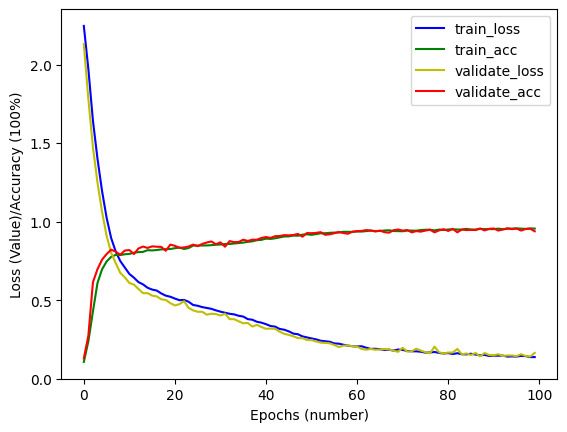

In [19]:
tl = np.load("files/tl.npy")
ta = np.load("files/ta.npy")
vl = np.load("files/vl.npy")
va = np.load("files/va.npy")


plt.xlabel('Epochs (number)')
plt.ylabel('Loss (Value)/Accuracy (100%)')
plt.plot(range(epochs), tl, color='b', label='train_loss')
plt.plot(range(epochs), ta, color='g', label='train_acc')
plt.plot(range(epochs), vl, color='y', label='validate_loss')
plt.plot(range(epochs), va, color='r', label='validate_acc')
plt.legend()

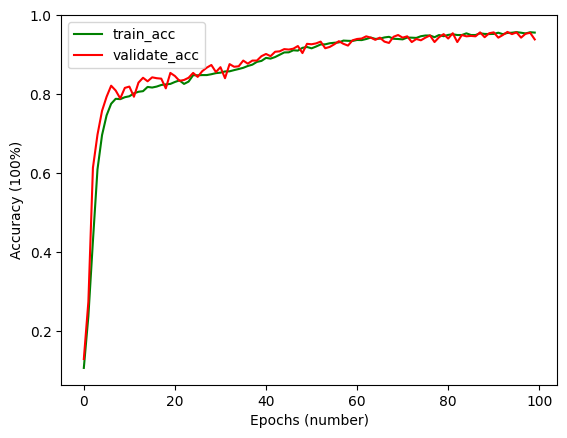

In [21]:
vl = np.load("files/vl.npy")
va = np.load("files/va.npy")
plt.xlabel('Epochs (number)')
plt.ylabel('Accuracy (100%)')
plt.plot(range(epochs), ta, color='g', label='train_acc')
plt.plot(range(epochs), va, color='r', label='validate_acc')
plt.legend()